# Diffusion models

In [1]:
%load_ext autoreload
%autoreload 2

### Required imports

In [2]:
import torch
import sys

from pathlib import Path
from matplotlib import pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

project_root = Path().absolute().parent
sys.path.append(str(project_root))
project_root

PosixPath('/home/aorellan/DiffusionArcade')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n\n")

if device.type == "cuda":
    !nvidia-smi

Using device: cuda


Tue May 13 21:29:30 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   36C    P0              22W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----

In [4]:
from src.diffusion.model import login_huggingface
from src.utils import show_images, make_grid

login_huggingface()

### Dataset

In [5]:
dataset = load_dataset(
    "imagefolder",
    data_dir="../screens/",
    split="train"
)

Resolving data files:   0%|          | 0/1592 [00:00<?, ?it/s]

In [6]:
dataset

Dataset({
    features: ['image'],
    num_rows: 1592
})

In [7]:
split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

In [8]:
image_size = 128
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.Grayscale(num_output_channels=1),   # → single‐channel “L” image
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def transform(examples):
    imgs = [preprocess(img) for img in examples["image"]]
    return {"image": imgs}

train_dataset.set_transform(transform)
val_dataset.set_transform(transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in training dataset:


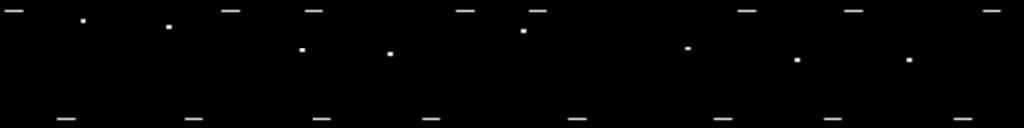

In [9]:
train_batch_images = next(iter(train_dataloader))["image"].to(device)[:8]
print("X shape:", train_batch_images.shape)

print('Batch of images in training dataset:')
show_images(train_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in validation dataset:


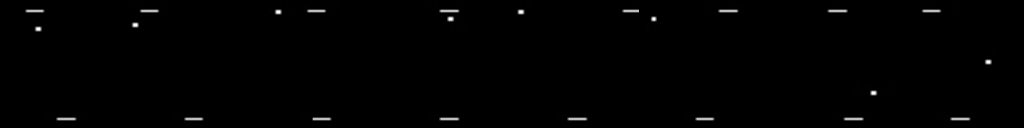

In [10]:
val_batch_images = next(iter(val_dataloader))["image"].to(device)[:8]
print("X shape:", val_batch_images.shape)

print('Batch of images in validation dataset:')
show_images(val_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

## Forward diffusion process

In [11]:
from diffusers import DDIMScheduler # We can also use DDPM scheduler, but this requires more steps

timesteps = 1000

schedulers = {
    "cosine": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="squaredcos_cap_v2"
    ),
    "linear": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="linear"
    ),
}

The forward diffusion process progressively adds noise to the original image $\mathbf{x}_0$ as timestep $t$ increases.

The process is defined by the re-parameterization formula:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
    = \mathcal{N}\!\bigl(
        \mathbf{x}_t;\,
        \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
        (1 - \bar{\alpha}_t)\,\mathbf{I}
      \bigr)
$$

where:

* $\mathbf{x}_t$ — noisy image at timestep $t$  
* $\sqrt{\bar{\alpha}_t}$ — scales down the original image  
* $1-\bar{\alpha}_t$ — variance of the added Gaussian noise

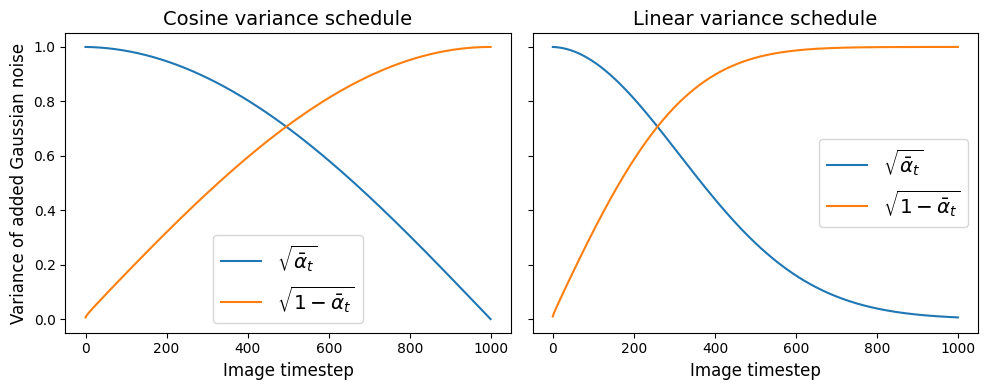

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (name, sched) in zip(axes, schedulers.items()):
    alphas_cumprod = sched.alphas_cumprod.cpu()
    
    ax.plot(
        alphas_cumprod ** 0.5,
        label=r"$\sqrt{\bar{\alpha}_t}$"
    )
    ax.plot(
        (1 - alphas_cumprod) ** 0.5,
        label=r"$\sqrt{1 - \bar{\alpha}_t}$"
    )
    ax.set_title(f"{name.capitalize()} variance schedule", fontsize=14)
    ax.set_xlabel("Image timestep", fontsize=12)
    ax.legend(fontsize="x-large")
    
axes[0].set_ylabel("Variance of added Gaussian noise", fontsize=12)

plt.tight_layout()
plt.show()

The more time steps, the more noise is added to the original image $\mathbf{x}_0$

In [13]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

The following images demonstrate the progressive addition of noise to the original image $\mathbf{x}_0$ across different timesteps. The sequence shows a gradual transition from minimal noise in the initial images to almost complete noise in the final image.

Noisy X shape torch.Size([8, 1, 128, 128])


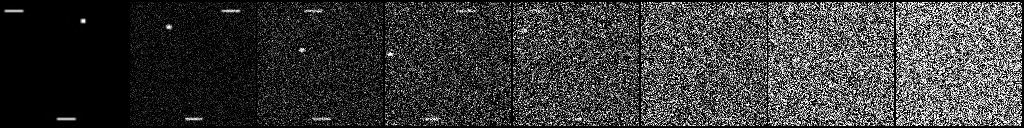

In [14]:
noise = torch.randn_like(train_batch_images) # same shape as xb: [Batch size, Channels, Height, Width]

noisy_train_batch_images = schedulers["cosine"].add_noise(train_batch_images, noise, timesteps)
print("Noisy X shape", train_batch_images.shape)
show_images(noisy_train_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

## Training loop for a diffusion model that generates Pong images

In [15]:
from src.diffusion.model import DiffusionModel, load_config

In [16]:
config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size=config['training_images']['image_size']
in_channels=config['training_images']['in_channels']
out_channels=config['training_images']['out_channels']
timesteps = config['training_images']['timesteps']
beta_schedule=config['training_images']['beta_schedule']

model = DiffusionModel(
    image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule=beta_schedule,
)

In [18]:
epochs = config["training_images"]["epochs"]
lr = config["training_images"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": config["wandb"]["run_name"],
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

wandb: Currently logged in as: adriana-orellana-torrico to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]/home/aorellan/miniconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.57s/it, loss=0.0254]


Epoch [1/30] Train Loss: 0.1429 Val Loss: 0.0329


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0182]


Epoch [2/30] Train Loss: 0.0246 Val Loss: 0.0172


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.015]


Epoch [3/30] Train Loss: 0.0166 Val Loss: 0.0146


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0139]


Epoch [4/30] Train Loss: 0.0123 Val Loss: 0.0103


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00831]


Epoch [5/30] Train Loss: 0.0090 Val Loss: 0.0084


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00579]


Epoch [6/30] Train Loss: 0.0073 Val Loss: 0.0066


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00499]


Epoch [7/30] Train Loss: 0.0055 Val Loss: 0.0061


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00437]


Epoch [8/30] Train Loss: 0.0052 Val Loss: 0.0055


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00465]


Epoch [9/30] Train Loss: 0.0054 Val Loss: 0.0057


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00359]


Epoch [10/30] Train Loss: 0.0048 Val Loss: 0.0043


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00315]


Epoch [11/30] Train Loss: 0.0036 Val Loss: 0.0031


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00271]


Epoch [12/30] Train Loss: 0.0036 Val Loss: 0.0029


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00263]


Epoch [13/30] Train Loss: 0.0032 Val Loss: 0.0029


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0025]


Epoch [14/30] Train Loss: 0.0028 Val Loss: 0.0024


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00264]


Epoch [15/30] Train Loss: 0.0029 Val Loss: 0.0028


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00244]


Epoch [16/30] Train Loss: 0.0027 Val Loss: 0.0024


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00217]


Epoch [17/30] Train Loss: 0.0022 Val Loss: 0.0020


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00171]


Epoch [18/30] Train Loss: 0.0024 Val Loss: 0.0019


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00167]


Epoch [19/30] Train Loss: 0.0019 Val Loss: 0.0026


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00274]


Epoch [20/30] Train Loss: 0.0021 Val Loss: 0.0023


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00183]


Epoch [21/30] Train Loss: 0.0021 Val Loss: 0.0024


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00179]


Epoch [22/30] Train Loss: 0.0024 Val Loss: 0.0023


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00206]


Epoch [23/30] Train Loss: 0.0020 Val Loss: 0.0017


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00137]


Epoch [24/30] Train Loss: 0.0016 Val Loss: 0.0015


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00202]


Epoch [25/30] Train Loss: 0.0018 Val Loss: 0.0019


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00266]


Epoch [26/30] Train Loss: 0.0017 Val Loss: 0.0015


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00256]


Epoch [27/30] Train Loss: 0.0025 Val Loss: 0.0018


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0019]


Epoch [28/30] Train Loss: 0.0018 Val Loss: 0.0017


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00152]


Epoch [29/30] Train Loss: 0.0015 Val Loss: 0.0015


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00105]


Epoch [30/30] Train Loss: 0.0014 Val Loss: 0.0013


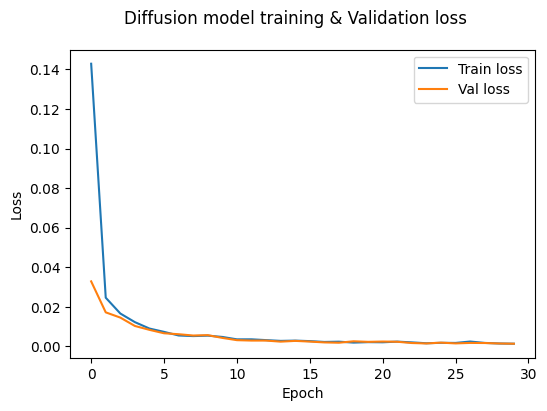

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Diffusion model training & Validation loss")

ax.plot(train_losses, label="Train loss")
ax.plot(val_losses, label="Val loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

## Testing the diffusion model: Pong image generation

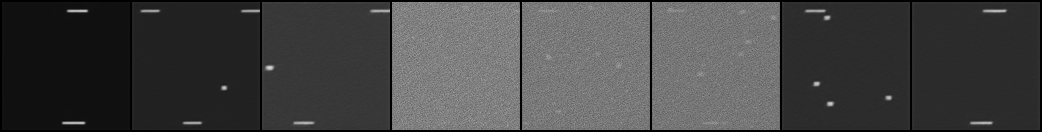

In [24]:
n_images = 8
n_channels = 1
num_inference_steps = 1000

sample = model.generate(n_images, n_channels, num_inference_steps)

show_images(sample)

## Using VAE to generate latent representations (z)

In [29]:
from src.diffusion.model import load_config

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size=config['training_latents']['image_size']

dataset = load_dataset(
    "imagefolder",
    data_dir="../screens/",
    split="train"
)

split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

Resolving data files:   0%|          | 0/1592 [00:00<?, ?it/s]

#### 1. Testing VAE: encoding Pong frames and decoding them to reconstruct the original images

In [17]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").eval().to(device)

# Keep frozen
vae.requires_grad_(False)

SCALE = vae.config.scaling_factor

#### Encoding Pong images

In [18]:
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def encode_batch(examples):
    # convert every image to RGB just to be compatible with VAE format
    imgs = [preprocess(img.convert("RGB")) for img in examples["image"]]
    
    # stack into [B, 1, H, W] and move to device
    batch = torch.stack(imgs, dim=0).to(device)
    
    # encode and sample latents under no_grad
    with torch.no_grad():
        latents = vae.encode(batch).latent_dist.sample() * SCALE

    return {"latents": latents.cpu()}

train_dataset.set_transform(encode_batch)
val_dataset.set_transform(encode_batch)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [19]:
for batch in train_dataloader:
    print('Encoded images -> latents shape:', batch['latents'].shape)
    break

Encoded images -> latents shape: torch.Size([64, 4, 16, 16])


#### Decoding latent representations

torch.Size([64, 3, 128, 128])
Decoded latents batch: torch.Size([8, 3, 128, 128])


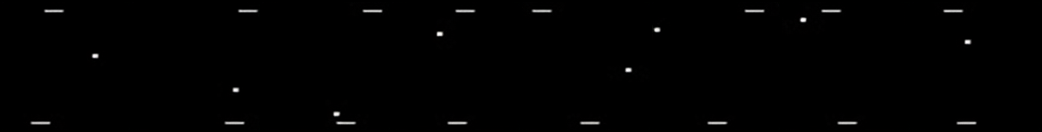

In [25]:
def decode_latents_to_tensor(latents, vae, scale=SCALE, device=device):
    lat = latents.to(device) / scale
    with torch.no_grad():
        dec = vae.decode(lat).sample       # -> [B, 3, H, W], roughly [-1,1]
        print(dec.shape)
    return dec.cpu()

batch = next(iter(train_dataloader))
latents = batch["latents"]               # shape [B, C, h, w]

decoded_tensor = decode_latents_to_tensor(latents, vae)[:8]
print(f"Decoded latents batch:", decoded_tensor.shape)

show_images(decoded_tensor)

## Using VAE latent representations in the diffusion model

In [16]:
import math

from src.diffusion.model import LatentDiffusionModel, login_huggingface, load_config
from diffusers import AutoencoderKL

config = load_config("../config.yaml")

login_huggingface()

### Step 1: Load the VAE and freeze its weights

In [19]:
vae_name = config["training_latents"]["vae_name"]

vae = AutoencoderKL.from_pretrained(vae_name).eval().to(device)
vae.requires_grad_(False)

SCALE = vae.config.scaling_factor
latent_channels = vae.config.latent_channels
latent_size = int(math.sqrt(vae.config.sample_size))

print('The VAE was correctly instantiated!')

The VAE was correctly instantiated!


#### Step 2: Utils to preprocess, encode images to latent representations, and decode them

In [20]:
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def encode_batch(examples):
    # convert every image to RGB to be compatible with the VAE format
    imgs = [preprocess(img.convert("RGB")) for img in examples["image"]]
    batch = torch.stack(imgs, dim=0).to(device)
    
    # encode and sample latents
    with torch.no_grad():
        latents = vae.encode(batch).latent_dist.sample() * SCALE

    return {"latents": latents.cpu()}


def decode_latents_to_tensor(latents, vae, scale=SCALE, device=device):
    lat = latents.to(device) / scale
    with torch.no_grad():
        dec = vae.decode(lat).sample       # -> [B, 3, H, W], roughly [-1,1]

    return dec.cpu()

In [21]:
print("Encoding images...")
batch_size = config["training_latents"]["batch_size"]

train_dataset.set_transform(encode_batch)
val_dataset.set_transform(encode_batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Latent representations generated successfully!")

Encoding images...
Latent representations generated successfully!


In [23]:
for batch in train_dataloader:
    print("Shape of a batch of latent representations:", batch["latents"].shape) # This should be [B, C, H, W]
    break

Shape of a batch of latent representations: torch.Size([32, 4, 16, 16])


In [22]:
model = LatentDiffusionModel(latent_channels=latent_channels, latent_size=latent_size)

In [24]:
epochs = config["training_latents"]["epochs"]
lr = config["training_latents"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": config['wandb']['run_name'],
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

wandb: Currently logged in as: adriana-orellana-torrico to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/30:   0%|                                                                                                                          | 0/40 [00:00<?, ?it/s]/home/aorellan/miniconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  4.00it/s, loss=0.207]


Epoch [1/30] Train Loss: 0.3426 Val Loss: 0.16583367437124252


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.129]


Epoch [2/30] Train Loss: 0.1368 Val Loss: 0.11455532163381577


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.119]


Epoch [3/30] Train Loss: 0.1034 Val Loss: 0.08736245110630989


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.69it/s, loss=0.0721]


Epoch [4/30] Train Loss: 0.0862 Val Loss: 0.07663236968219281


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.113]


Epoch [5/30] Train Loss: 0.0798 Val Loss: 0.07816260866820812


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s, loss=0.0543]


Epoch [6/30] Train Loss: 0.0742 Val Loss: 0.06193260848522186


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0585]


Epoch [7/30] Train Loss: 0.0580 Val Loss: 0.06508158408105373


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0384]


Epoch [8/30] Train Loss: 0.0644 Val Loss: 0.06667258143424988


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0461]


Epoch [9/30] Train Loss: 0.0570 Val Loss: 0.05721794292330742


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0575]


Epoch [10/30] Train Loss: 0.0550 Val Loss: 0.054150499403476715


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0752]


Epoch [11/30] Train Loss: 0.0592 Val Loss: 0.05405845679342747


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.66it/s, loss=0.0441]


Epoch [12/30] Train Loss: 0.0490 Val Loss: 0.057273126766085626


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0808]


Epoch [13/30] Train Loss: 0.0503 Val Loss: 0.058664141595363616


Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.123]


Epoch [14/30] Train Loss: 0.0500 Val Loss: 0.047381574660539626


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0591]


Epoch [15/30] Train Loss: 0.0487 Val Loss: 0.05262852348387241


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0552]


Epoch [16/30] Train Loss: 0.0393 Val Loss: 0.04391839280724526


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s, loss=0.0376]


Epoch [17/30] Train Loss: 0.0405 Val Loss: 0.03964937143027782


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0845]


Epoch [18/30] Train Loss: 0.0426 Val Loss: 0.039174138009548186


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.69it/s, loss=0.0457]


Epoch [19/30] Train Loss: 0.0397 Val Loss: 0.03985815066844225


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s, loss=0.0494]


Epoch [20/30] Train Loss: 0.0444 Val Loss: 0.050164519995450976


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0534]


Epoch [21/30] Train Loss: 0.0422 Val Loss: 0.04009133242070675


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0406]


Epoch [22/30] Train Loss: 0.0417 Val Loss: 0.043674699403345583


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.69it/s, loss=0.0286]


Epoch [23/30] Train Loss: 0.0380 Val Loss: 0.04213264584541321


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0665]


Epoch [24/30] Train Loss: 0.0401 Val Loss: 0.04107032082974911


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s, loss=0.0616]


Epoch [25/30] Train Loss: 0.0424 Val Loss: 0.040848986245691776


Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s, loss=0.046]


Epoch [26/30] Train Loss: 0.0394 Val Loss: 0.03169150333851576


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.67it/s, loss=0.0309]


Epoch [27/30] Train Loss: 0.0371 Val Loss: 0.04008576031774282


Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.036]


Epoch [28/30] Train Loss: 0.0377 Val Loss: 0.03708569258451462


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.69it/s, loss=0.0366]


Epoch [29/30] Train Loss: 0.0395 Val Loss: 0.03346186596900225


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.68it/s, loss=0.0307]


Epoch [30/30] Train Loss: 0.0314 Val Loss: 0.03968665078282356


In [25]:
model

In [26]:
# To save the model locally
torch.save(model.model.state_dict(), "latent_diffusion_unet.pth")

In [10]:
# to load the saved model, uncomment the following lines
# model = LatentDiffusionModel()
# model.model.load_state_dict(torch.load("latent_diffusion_unet.pth"))
# model.model.eval()
# print('Loaded model!')

Loaded model!


#### Evaluate the model

Latent representations shape: torch.Size([8, 4, 16, 16])
torch.Size([8, 3, 128, 128])
Decoded tensor shape: torch.Size([8, 3, 128, 128])


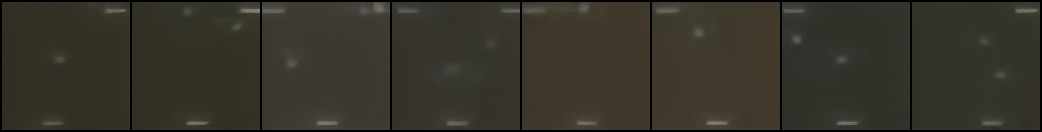

In [27]:
n_images = 8
num_inference_steps = 1000

latents = model.generate_latents(n_images, num_inference_steps)
print("Latent representations shape:", latents.shape)

decoded_tensor = decode_latents_to_tensor(latents, vae)
print("Decoded tensor shape:", decoded_tensor.shape)

show_images(decoded_tensor)

## References

1. **Hugging Face Diffusion Course, Unit 0: Introduction to Diffusion Models**  
   Available online: [https://huggingface.co/learn/diffusion-course/en/unit0/1](https://huggingface.co/learn/diffusion-course/en/unit0/1)

2. **Ho, J., Jain, A., & Abbeel, P.** (2020). *Denoising Diffusion Probabilistic Models*.  
   arXiv preprint arXiv:2006.11239. [PDF](https://arxiv.org/pdf/2006.11239)

3. **Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B.** (2022). *High-Resolution Image Synthesis with Latent Diffusion Models*.  
   arXiv preprint arXiv:2208.11970. [PDF](https://arxiv.org/pdf/2208.11970)
